In [15]:
# Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

In [30]:
# Step 2: Load Data
# ========================
df = pd.read_csv(r"C:\Users\bbuser\Downloads\ai4i2020.csv")   # change file name if needed
print("Shape:", df.shape)
print("\nMissing values:\n", df.isna().sum())


Shape: (10000, 14)

Missing values:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


In [31]:
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [23]:
# Step 3: Preprocessing

df_proc = df.copy()

# ---- Binary Target ----
y_binary = df_proc["Machine failure"]

# ---- Multi-class Target ----
failure_types = ["TWF","HDF","PWF","OSF","RNF"]
df_proc["failure_type"] = df_proc[failure_types].idxmax(axis=1)  # pick the failure type column with 1

# This is the multi-class target
y_multi = df_proc["failure_type"]

# ---- Drop unused columns (including TWF, HDF, etc.) ----
X = df_proc.drop(columns=["UDI","Product ID","Machine failure"] + failure_types + ["failure_type"])

# ---- Encode categorical "Type" ----
X = pd.get_dummies(X, columns=["Type"], drop_first=True)

# ---- Encode failure_type for multi-class ----
le = LabelEncoder()
y_multi_enc = le.fit_transform(y_multi)

# ---- Train/Test Split ----
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y_binary, test_size=0.3, stratify=y_binary, random_state=42
)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X, y_multi_enc, test_size=0.3, stratify=y_multi_enc, random_state=42
)

# ---- Scale numerical features ----
scaler = StandardScaler()
X_train_b = scaler.fit_transform(X_train_b)
X_test_b = scaler.transform(X_test_b)

X_train_m = scaler.fit_transform(X_train_m)
X_test_m = scaler.transform(X_test_m)



=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9914    0.8326    0.9051      2898
           1     0.1431    0.7941    0.2425       102

    accuracy                         0.8313      3000
   macro avg     0.5672    0.8134    0.5738      3000
weighted avg     0.9625    0.8313    0.8826      3000

ROC-AUC: 0.8885099933693285
Avg Precision (AP): 0.37982309894498556

=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9800    0.9972    0.9885      2898
           1     0.8431    0.4216    0.5621       102

    accuracy                         0.9777      3000
   macro avg     0.9116    0.7094    0.7753      3000
weighted avg     0.9753    0.9777    0.9740      3000

ROC-AUC: 0.9673016549615017
Avg Precision (AP): 0.7083218226369161

=== Gradient Boosting ===
              precision    recall  f1-score   support

           0     0.9860    0.9976    0.9918      2898
           1     0.8971

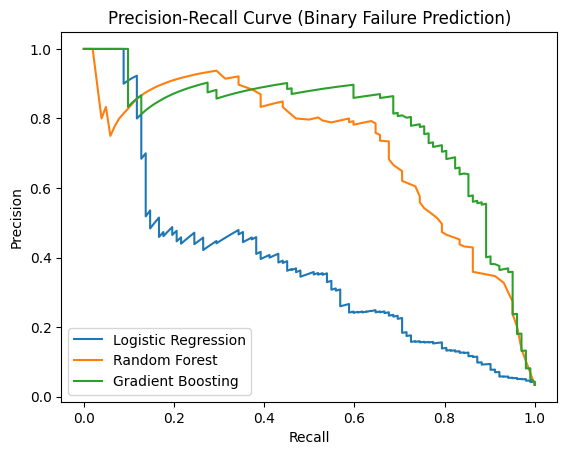

In [24]:
# Step 4: Model 1 - Failure Prediction (Binary)

models_binary = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

for name, model in models_binary.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_b, y_train_b)
    y_pred = model.predict(X_test_b)
    y_score = model.predict_proba(X_test_b)[:,1] if hasattr(model,"predict_proba") else model.decision_function(X_test_b)

    # Metrics
    print(classification_report(y_test_b, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_test_b, y_score))
    print("Avg Precision (AP):", average_precision_score(y_test_b, y_score))

    # Precision-Recall Curve
    prec, rec, _ = precision_recall_curve(y_test_b, y_score)
    plt.plot(rec, prec, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Binary Failure Prediction)")
plt.legend()
plt.show()


=== Decision Tree ===
              precision    recall  f1-score   support

         HDF       0.82      0.89      0.85        35
         OSF       0.72      0.54      0.62        24
         PWF       0.75      0.67      0.71        27
         RNF       0.00      0.00      0.00         5
         TWF       0.99      0.99      0.99      2909

    accuracy                           0.99      3000
   macro avg       0.66      0.62      0.63      3000
weighted avg       0.98      0.99      0.98      3000



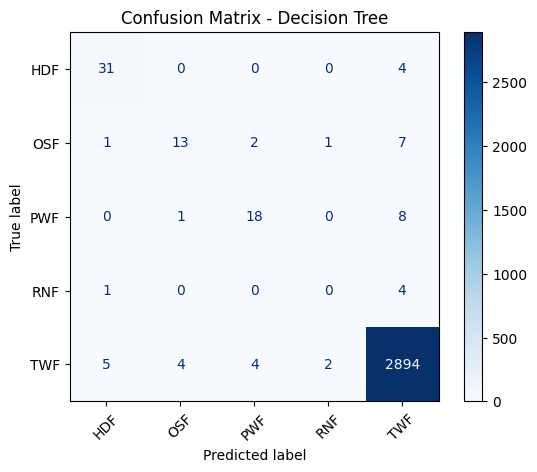


=== SVM ===


C:\Users\bbuser\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bbuser\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bbuser\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

         HDF       0.00      0.00      0.00        35
         OSF       0.75      0.38      0.50        24
         PWF       0.89      0.30      0.44        27
         RNF       0.00      0.00      0.00         5
         TWF       0.98      1.00      0.99      2909

    accuracy                           0.97      3000
   macro avg       0.52      0.33      0.39      3000
weighted avg       0.96      0.97      0.97      3000



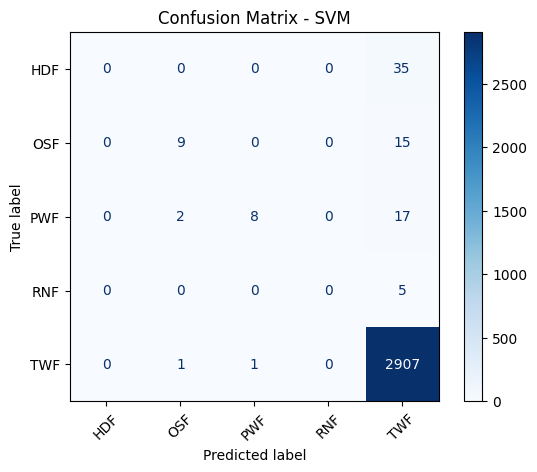


=== Naive Bayes ===
              precision    recall  f1-score   support

         HDF       0.31      0.63      0.41        35
         OSF       0.27      0.71      0.40        24
         PWF       0.18      0.37      0.24        27
         RNF       0.00      0.00      0.00         5
         TWF       0.99      0.95      0.97      2909

    accuracy                           0.94      3000
   macro avg       0.35      0.53      0.40      3000
weighted avg       0.97      0.94      0.95      3000



C:\Users\bbuser\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bbuser\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bbuser\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


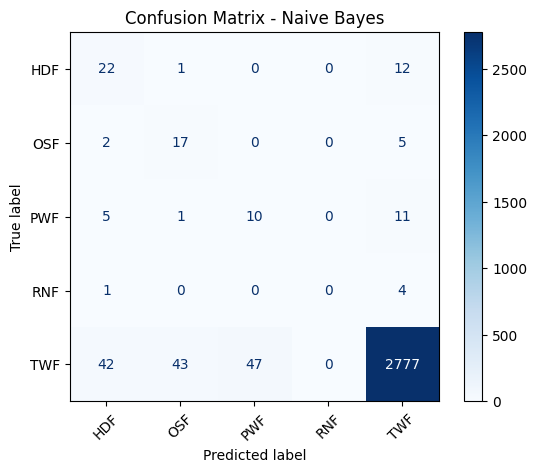


=== XGBoost ===


C:\Users\bbuser\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:09:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

         HDF       0.91      0.91      0.91        35
         OSF       0.80      0.67      0.73        24
         PWF       0.79      0.56      0.65        27
         RNF       1.00      0.20      0.33         5
         TWF       0.99      1.00      0.99      2909

    accuracy                           0.99      3000
   macro avg       0.90      0.67      0.72      3000
weighted avg       0.99      0.99      0.99      3000



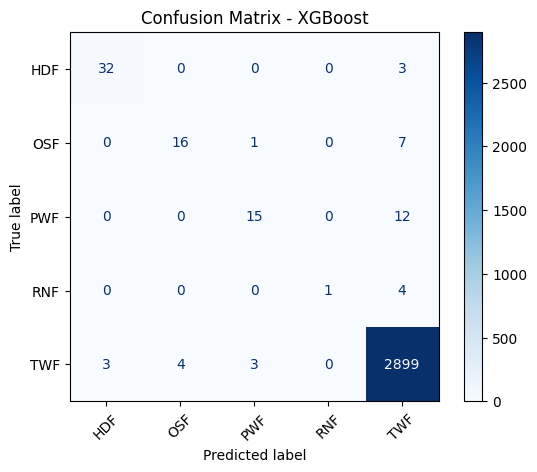

In [25]:
# Step 5: Model 2 - Failure Type Classification (Multi-class)

models_multi = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

for name, model in models_multi.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_m, y_train_m)
    y_pred = model.predict(X_test_m)

    # Metrics
    print(classification_report(y_test_m, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test_m, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [27]:

# Step 6: Summary & Insights


print("🔹 Model 1: Binary Failure Prediction (Machine Failure Yes/No)")
print("- Focus is on Recall to catch as many failures as possible (avoiding downtime).")
print("- Logistic Regression: high recall but low precision → catches most failures but many false alarms.")
print("- Random Forest & Gradient Boosting: better balance of Precision & Recall, ROC-AUC and Average Precision are higher.")
print("- Use Random Forest or Gradient Boosting in production for best trade-off between catching failures and avoiding false alarms.\n")

print("🔹 Model 2: Failure Type Classification (TWF, HDF, PWF, OSF, RNF)")
print("- Confusion matrices show which failure types are most confused (e.g., TWF vs HDF).")
print("- Decision Tree: interpretable, decent F1-scores per class.")
print("- XGBoost: generally gives best macro-F1 and overall accuracy.")
print("- SVM & Naive Bayes: may struggle if classes are imbalanced.\n")

print("✅ Key Trade-offs & Next Steps:")
print("- High Recall → fewer missed failures, but more false alarms.")
print("- High Precision → fewer false alarms, risk of missing failures.")
print("- Next Steps:")
print("   • Consider ensemble models (Voting, Stacking) for better performance.")
print("   • Apply class imbalance techniques (SMOTE, undersampling) for rare failure types.")
print("   • Explore cost-sensitive learning to penalize missing failures more heavily.")
print("   • Add time-series features (lagged sensors, rolling averages) to improve predictive power.")


🔹 Model 1: Binary Failure Prediction (Machine Failure Yes/No)
- Focus is on Recall to catch as many failures as possible (avoiding downtime).
- Logistic Regression: high recall but low precision → catches most failures but many false alarms.
- Random Forest & Gradient Boosting: better balance of Precision & Recall, ROC-AUC and Average Precision are higher.
- Use Random Forest or Gradient Boosting in production for best trade-off between catching failures and avoiding false alarms.

🔹 Model 2: Failure Type Classification (TWF, HDF, PWF, OSF, RNF)
- Confusion matrices show which failure types are most confused (e.g., TWF vs HDF).
- Decision Tree: interpretable, decent F1-scores per class.
- XGBoost: generally gives best macro-F1 and overall accuracy.
- SVM & Naive Bayes: may struggle if classes are imbalanced.

✅ Key Trade-offs & Next Steps:
- High Recall → fewer missed failures, but more false alarms.
- High Precision → fewer false alarms, risk of missing failures.
- Next Steps:
   • Co